# NLP on Biogas Patent Data

# 1. Data preparation and basic analysis

In [2]:
#Load packages
library(dplyr)
library(tidytext)
library(lubridate)
library(tm)
library(tidyverse)
library(stringr)
library(ggplot2)
library(wordcloud)
library(RColorBrewer)
library(readr)
library(tidyr)
library(igraph)
library(ggraph)
library(widyr)
library(topicmodels)
library(Matrix)
library(janeaustenr)
library(scales)
library(magrittr)
library(Matrix)
library(textstem)
library(DT)
library(tools)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Loading required package: NLP
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 2.2.1     v readr   1.1.1
v tibble  1.4.1     v purrr   0.2.4
v tidyr   0.7.2     v stringr 1.2.0
v ggplot2 2.2.1     v forcats 0.2.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x ggplot2::annotate()      masks NLP::annotate()
x lubridate::as.difftime() masks base::as.difftime()
x lubridate::date()        masks base::date()
x dplyr::filter()          masks stats::filter()
x lubridate::intersect()   masks base::intersect()
x dplyr::lag()             masks stats::lag()
x lubridate::setdiff()     masks base::setdiff()
x lubridate::union()       

In [3]:
# Set theme
theme_set(theme_minimal())

In [4]:
#Load data on food waste patents
df <- read.csv("biogas1.csv")

In [5]:
# Keep text only
df <- as.character(df$text)

In [6]:
# Clean up text
df <- removeNumbers(df) #remove the numbers from the text
df <- removePunctuation(df) # remove the punctuation

### Tokenize text and remove stop words

In [7]:
# Converting text vector into a dataframe
text_df <- data_frame(line = 1:length(df), text = df)

In [8]:
#Tokenize
tokenized <- text_df %>%
    unnest_tokens(word, text)

In [9]:
#Remove common stop words
data("stop_words")

# Custom stop words
additional_stop_words <- data_frame(word=c("figref", "idrefdrawingsfig", "bb", "xb", "patent", "document", 
                                           "xbsubsub", "fig"， "invention"),
                                   lexicon = rep("custom"))

#Bind stop word data
all_stops <- bind_rows(stop_words, additional_stop_words)

# Remove stops
clean_text_df <- tokenized %>% 
    anti_join(all_stops)

Joining, by = "word"


### Basic word count visualization

In [10]:
# Get count of top words
clean_text_df_count <- clean_text_df %>% 
    count(word, sort = TRUE)  %>% 
    filter(n > 2000)  %>% 
    mutate(word = reorder(word, n)) %>% 
    ggplot(aes(word,n)) +
    geom_col() +
    xlab(NULL) +
    coord_flip()
# clean_text_df_count

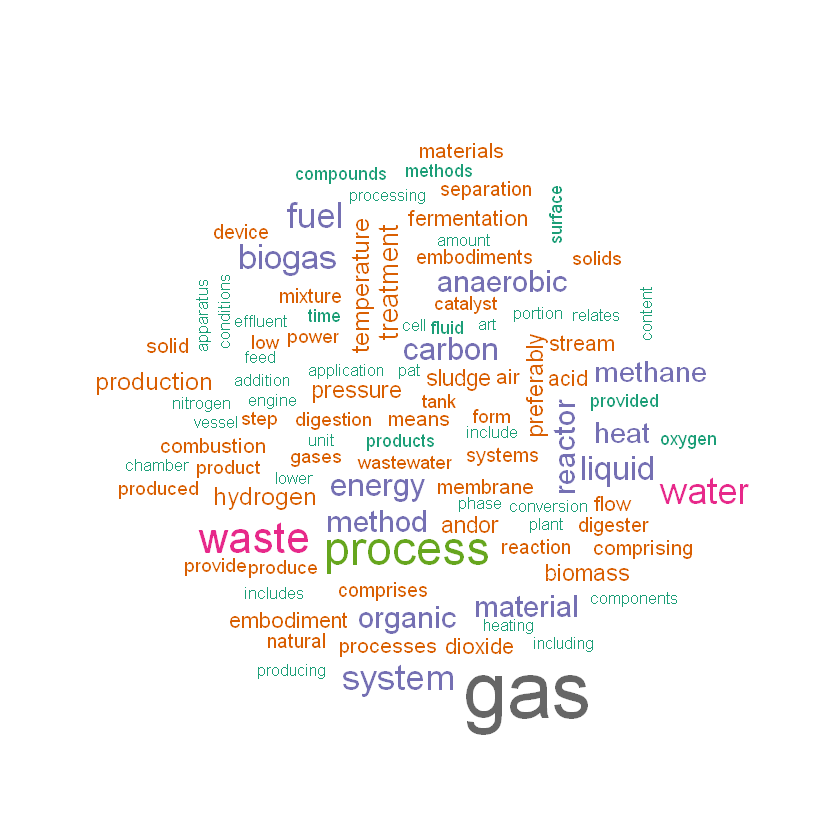

In [11]:
# Show wordcloud of top words
set.seed(0)
clean_text_df %>%
    count(word) %>%
    with(wordcloud(word, n, max.words = 100, colors=brewer.pal(8, "Dark2")))

# 2. TF-IDF

In [12]:
# Import data
df_with_patent_id <- read.csv("biogas1.csv", stringsAsFactors = F)

In [13]:
df_with_patent_id$country <- NULL
df_with_patent_id$title <- NULL
df_with_patent_id$abstract <- NULL

In [14]:
df_with_patent_id$Abstract <- df_with_patent_id$text
df_with_patent_id$text <- NULL

In [15]:
df_with_patent_id$Abstract <- as.character(df_with_patent_id$Abstract)  %>% 
    removeNumbers() %>% 
    removePunctuation()

In [16]:
a <- mdy(df_with_patent_id$IssueDate)
df_with_patent_id$IssueDate  <- as.factor(year(a))
# head(df_with_patent_id, n=20)

df_with_patent_id$PatentNo  <- NULL
# df_with_patent_id

In [17]:
abstract_words <- df_with_patent_id %>% 
    unnest_tokens(word, Abstract)  %>% 
    anti_join(all_stops) %>% 
    count(IssueDate, word, sort=TRUE) %>% 
    ungroup()

total_words <- abstract_words %>% 
    group_by(IssueDate) %>% 
    summarize(total = sum(n))

Joining, by = "word"


In [18]:
abstract_words <- left_join(abstract_words, total_words)
# abstract_words

Joining, by = "IssueDate"


Warning message in is.na(e1) | is.na(e2):
"longer object length is not a multiple of shorter object length"Warning message in `==.default`(IssueDate, c("2010", "2011", "2012", "2013", "2014", :
"longer object length is not a multiple of shorter object length"`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 204 rows containing non-finite values (stat_bin)."

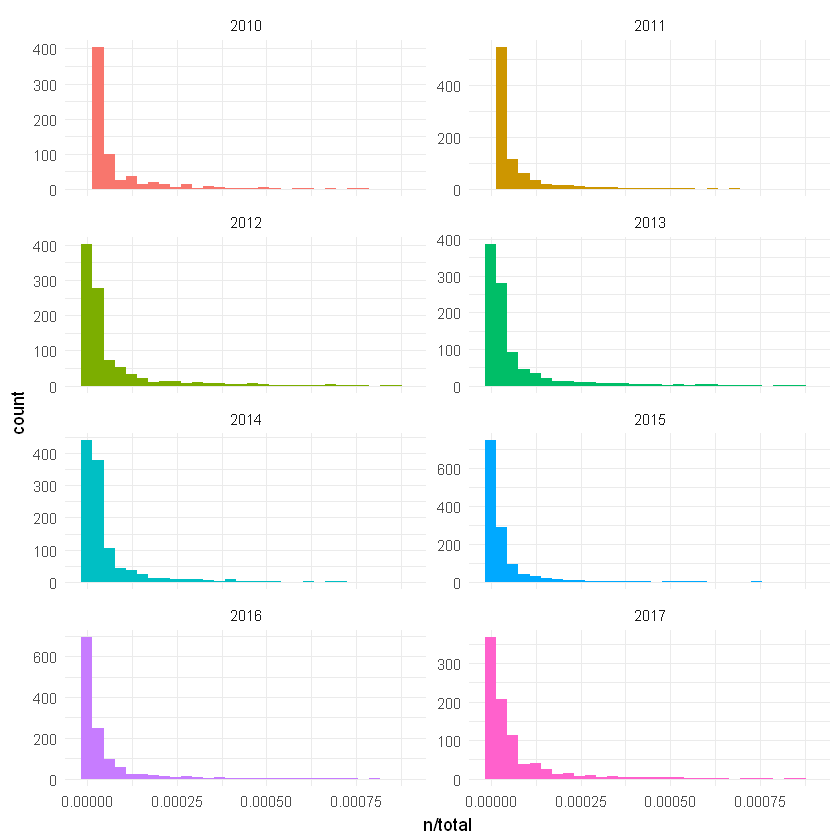

In [19]:
ggplot(subset(abstract_words, IssueDate == c("2010", "2011", "2012", "2013", "2014","2015","2016","2017","2018"), select=c(IssueDate:total)), 
       aes(n/total, fill = IssueDate)) +
  geom_histogram(show.legend = FALSE) +
  xlim(NA, 0.0009) +
  facet_wrap(~IssueDate, ncol = 2, scales = "free_y")

In [20]:
total_words <- df_with_patent_id %>% 
    count(IssueDate, sort=TRUE) 
# total_words

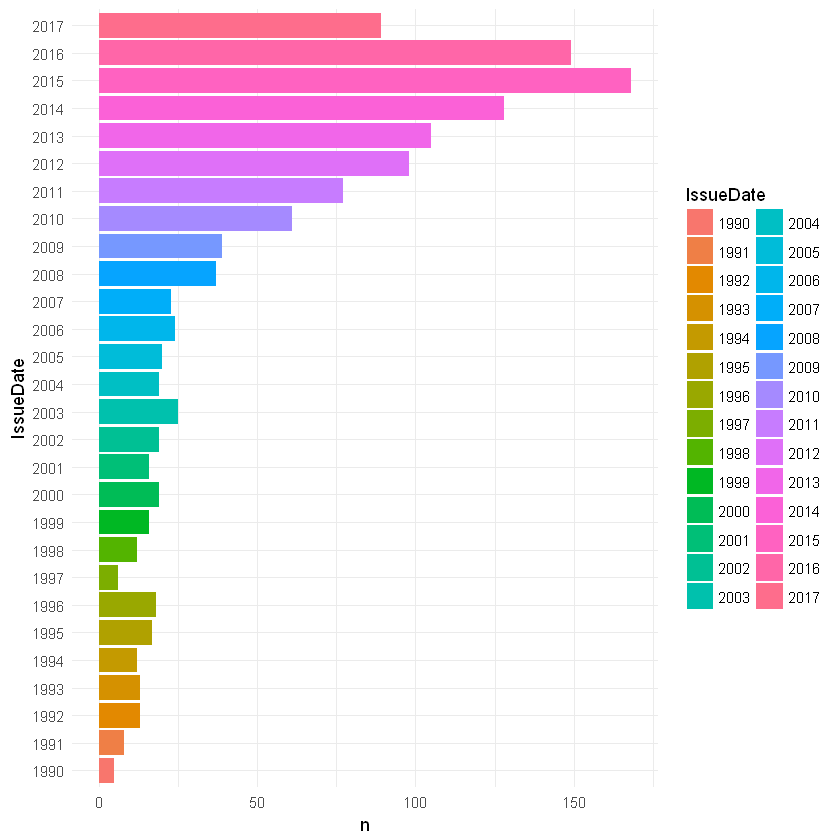

In [21]:
ggplot(data=subset(total_words, IssueDate %in% c("1990":"2018"))) +
    geom_col(aes(IssueDate, n, fill=IssueDate)) +
    coord_flip()

In [22]:
freq_by_rank <- abstract_words %>%
  group_by(IssueDate) %>%
  mutate(rank = row_number(),
         `term frequency` = n/total)

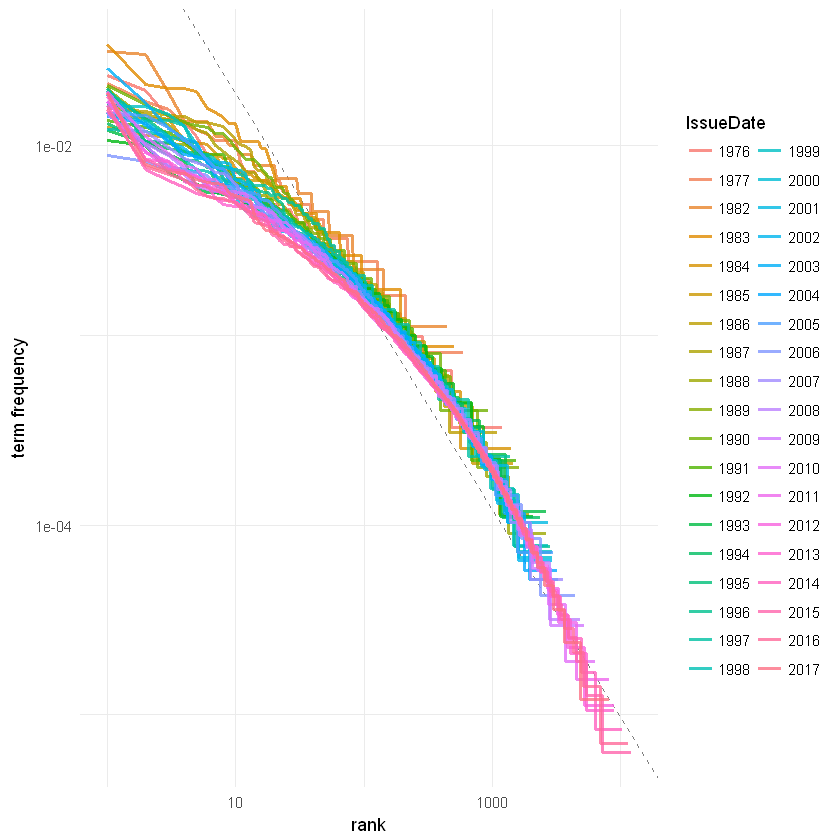

In [23]:
freq_by_rank %>%
  ggplot(aes(rank, `term frequency`, color = IssueDate)) +
  geom_abline(intercept = -0.62, slope = -1.1, color = "gray50", linetype = 2) +
  geom_line(size = 1.1, alpha = 0.8, show.legend = TRUE) +
  scale_x_log10() +
  scale_y_log10()

### TF-IDF on unigrams

In [24]:
abstract_tf_idf <- abstract_words %>% 
  bind_tf_idf(word, IssueDate,n)

In [25]:
abstract_tf_idf %>% 
  select(-total) %>% 
  arrange(desc(tf_idf))

IssueDate,word,n,tf,idf,tf_idf
1989,ifo,102,0.020576962,3.6375862,0.07485047
1984,tmea,58,0.014672401,3.6375862,0.05337212
1977,helleborus,19,0.015472313,2.9444390,0.04555728
1977,rhizomes,13,0.010586319,2.9444390,0.03117077
1982,peat,27,0.030201342,0.9295360,0.02807323
1976,broth,72,0.023567921,1.0726368,0.02527982
1977,sapogenin,10,0.008143322,2.9444390,0.02397752
1976,vitamin,43,0.014075286,1.6916760,0.02381082
1985,accretion,31,0.006520825,3.6375862,0.02372006
1976,helleborus,22,0.007201309,2.9444390,0.02120382


Selecting by tf_idf


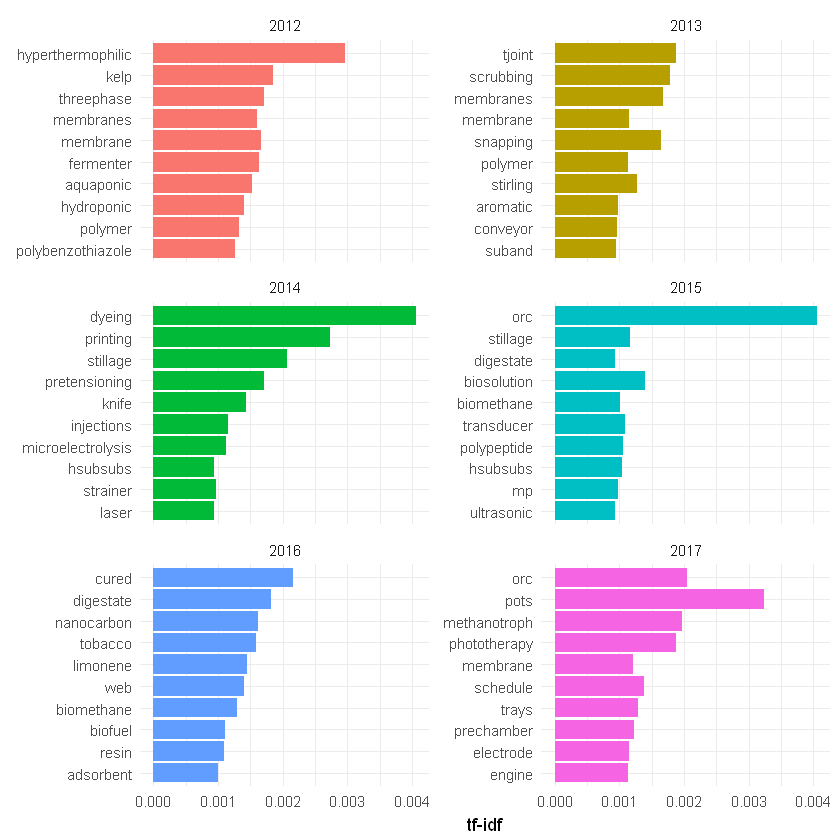

In [26]:
abstract_tf_idf %>% 
  subset(IssueDate %in% c("2012":"2018")) %>% 
  arrange(desc(tf_idf)) %>%
  mutate(word = factor(word, levels = rev(unique(word)))) %>%
  group_by(IssueDate) %>%
  top_n(10) %>%
  ungroup %>%
  ggplot(aes(word, tf_idf, fill = IssueDate)) +
  geom_col(show.legend = FALSE) +
  labs(x = NULL, y = "tf-idf") +
  facet_wrap(~IssueDate, ncol = 2, scales = "free_y") +
  coord_flip()

### TF-IDF on bigrams

In [27]:
abstract_bigrams <- df_with_patent_id %>% 
  unnest_tokens(bigram, Abstract, token = "ngrams", n = 2)

abstract_bigrams %>% 
  count(bigram, sort = TRUE)

bigrams_separated <- abstract_bigrams %>% 
  separate(bigram, c("word1", "word2"), sep = " ")

bigrams_filtered <- bigrams_separated %>%
  filter(!word1 %in% all_stops$word) %>%
  filter(!word2 %in% all_stops$word)

bigram_counts <- bigrams_filtered %>%
  count(word1, word2, sort = TRUE)

bigram,n
of the,38090
in the,17668
to the,11657
from the,7547
the invention,7273
can be,6811
and the,5976
in a,5847
at least,5463
such as,5358


In [28]:
bigrams_Query_filtered <- bigrams_separated %>%
  filter(!word1 %in% all_stops$word) %>%
  filter(!word2 %in% all_stops$word)

bigrams_Query_filtered_counts <- bigrams_Query_filtered %>% 
  count(word1, word2, sort = TRUE)

bigrams_Query_filtered_counts

bigrams_united <- bigrams_Query_filtered %>%
  unite(bigram, word1, word2, sep = " ")

word1,word2,n
carbon,dioxide,2913
natural,gas,1934
anaerobic,digestion,1438
fuel,cell,1003
organic,waste,983
gas,stream,880
waste,water,841
hydrogen,sulfide,814
synthesis,gas,759
prior,art,751


In [29]:
bigram_tf_idf <- bigrams_united %>%
  count(IssueDate, bigram) %>%
  bind_tf_idf(bigram, IssueDate, n) %>%
  arrange(desc(tf_idf))
bigram_tf_idf

IssueDate,bigram,n,tf,idf,tf_idf
1982,wave path,8,0.023809524,3.637586,0.08660919
1985,nutritional chain,41,0.020098039,3.637586,0.07310835
1982,methane generator,7,0.020833333,2.944439,0.06134248
1976,vitamin bsub,41,0.028571429,2.028148,0.05794709
1977,helleborus species,10,0.017953321,2.944439,0.05286246
1982,methane generators,5,0.014880952,2.944439,0.04381606
1982,solubilized peat,4,0.011904762,3.637586,0.04330460
1997,liquid materials,37,0.021046644,2.028148,0.04268571
1990,afterburning chamber,14,0.013972056,2.944439,0.04113987
1990,fish wastes,14,0.013972056,2.944439,0.04113987


Selecting by tf_idf


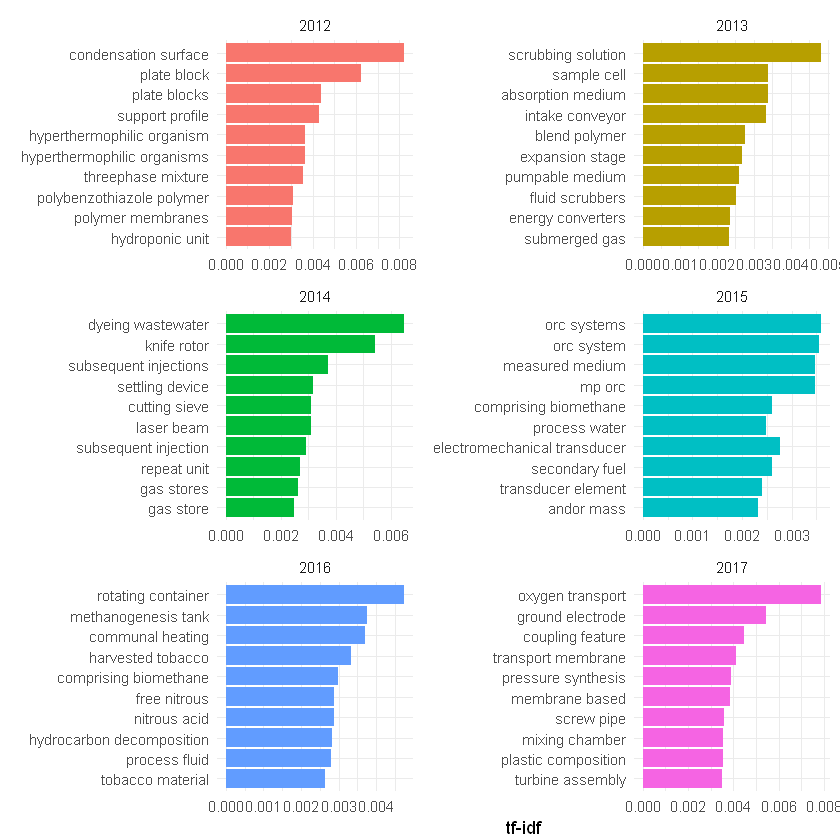

In [30]:
bigram_tf_idf %>%
  subset(IssueDate %in% c("2012":"2018")) %>% 
  arrange(desc(tf_idf)) %>%
  mutate(bigram = factor(bigram, levels = rev(unique(bigram)))) %>%
  group_by(IssueDate) %>%
  top_n(10) %>%
  ungroup %>%
  ggplot(aes(bigram, tf_idf, fill = IssueDate)) +
  geom_col(show.legend = FALSE) +
  labs(x = NULL, y = "tf-idf") +
  facet_wrap(~IssueDate, ncol = 2, scales = "free") +
  coord_flip()

### TF-IDF on trigrams

In [31]:
abstract_trigrams <- df_with_patent_id %>%
  unnest_tokens(trigram, Abstract, token = "ngrams", n = 3)

In [32]:
abstract_trigrams %>%
    count(trigram, sort=TRUE)

trigram,n
the present invention,4743
of the invention,4360
at least one,2627
of the present,2318
according to the,1918
us pat no,1512
the invention the,1393
one or more,1331
in order to,1329
the use of,1225


In [33]:
trigrams_separated <- abstract_trigrams %>% 
    separate(trigram, c("word1","word2","word3", sep = " "))

Warning message:
"Too few values at 2312173 locations: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ..."

In [34]:
trigrams_Query_filtered <- trigrams_separated %>% 
  filter(!word1 %in% all_stops$word) %>% 
  filter(!word2 %in% all_stops$word) %>%
  filter(!word3 %in% all_stops$word)

In [35]:
trigrams_Query_filtered_counts <- trigrams_Query_filtered %>% 
  count(word1, word2, word3, sort = TRUE)

In [36]:
trigrams_united <- trigrams_Query_filtered %>%
  unite(trigram, word1, word2, word3, sep = " ")

In [37]:
trigrams_tf_idf <- trigrams_united %>%
  count(IssueDate, trigram, sort =TRUE) %>%
  bind_tf_idf(trigram, IssueDate, n) %>%
  arrange(desc(tf_idf))

Selecting by tf_idf


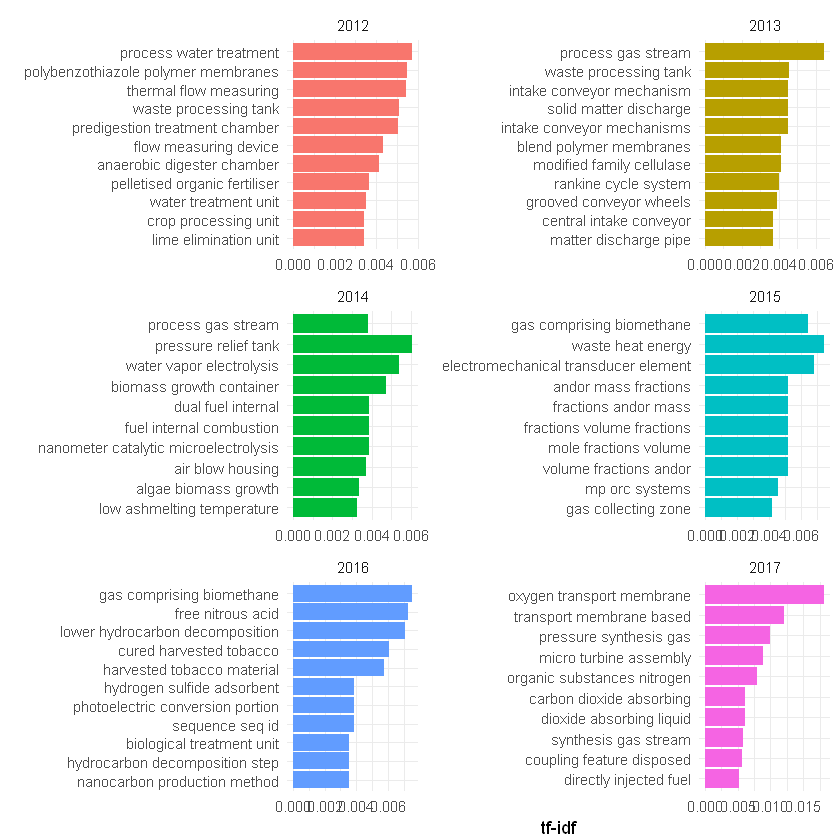

In [38]:
trigrams_tf_idf %>%
  subset(IssueDate %in% c("2012":"2018")) %>% 
  arrange(desc(tf_idf)) %>%
  mutate(trigram = factor(trigram, levels = rev(unique(trigram)))) %>%
  group_by(IssueDate) %>%
  top_n(10) %>%
  ungroup %>%
  ggplot(aes(trigram, tf_idf, fill = IssueDate)) +
  geom_col(show.legend = FALSE) +
  labs(x = NULL, y = "tf-idf") +
  facet_wrap(~IssueDate, ncol = 2, scales = "free") +
  coord_flip()

### Visualizing bigram networks

In [39]:
bigram_graph <- bigrams_Query_filtered_counts %>%
  filter(n > 100) %>%
  graph_from_data_frame()

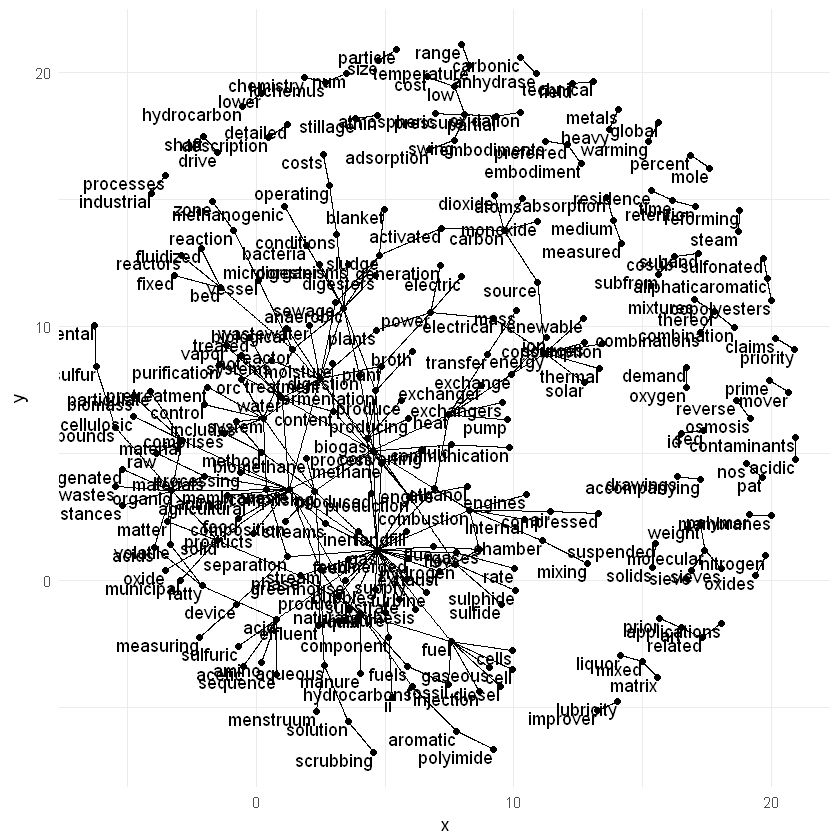

In [40]:
set.seed(2016)

ggraph(bigram_graph, layout = "fr") +
  geom_edge_link() +
  geom_node_point() +
  geom_node_text(aes(label = name), vjust = 1, hjust = 1)

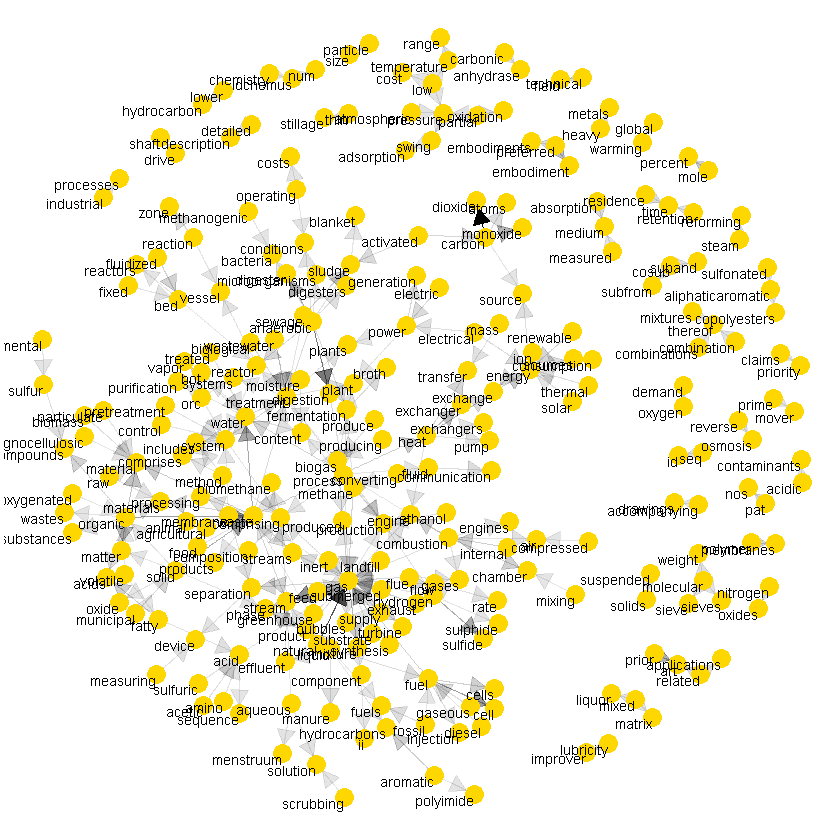

In [94]:
set.seed(2016)
a <- grid::arrow(type = "closed", length = unit(.15, "inches"))
ggraph(bigram_graph, layout = "fr") +
  geom_edge_link(aes(edge_alpha = n), show.legend = FALSE,
                 arrow = a, end_cap = circle(.07, 'inches')) +
  geom_node_point(color = "gold", size = 5) +
  geom_node_text(aes(label = name), vjust = 1, hjust = 1, size=3) +
  theme_void()

In [42]:
trigram_graph <- trigrams_Query_filtered_counts %>%
  filter(n > 40) %>%
  graph_from_data_frame()

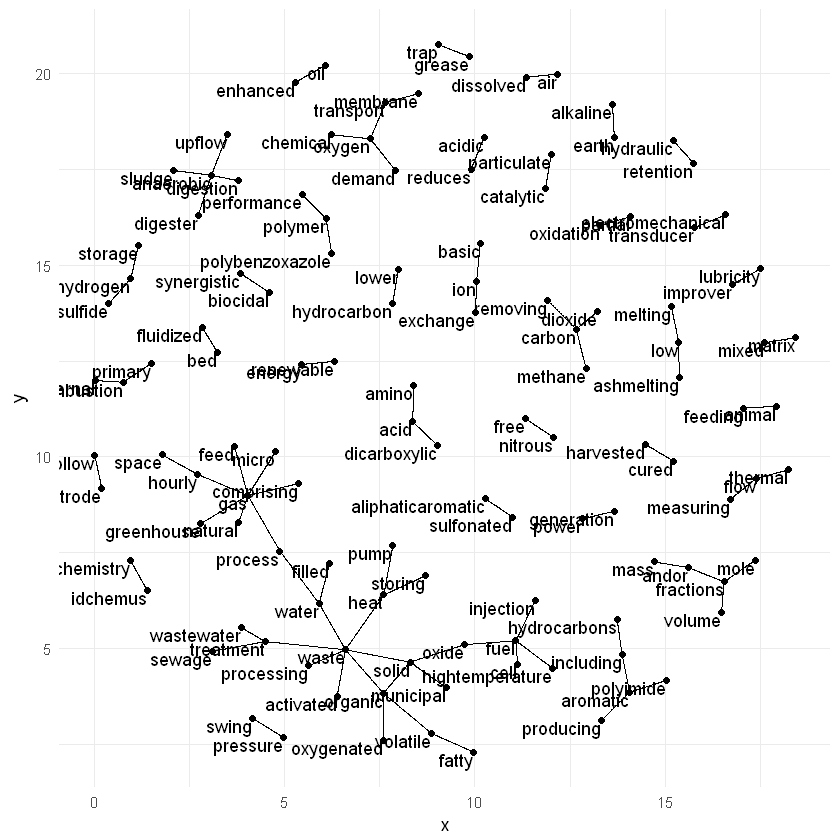

In [43]:
ggraph(trigram_graph, layout = "fr") +
  geom_edge_link() +
  geom_node_point() +
  geom_node_text(aes(label = name), vjust = 1, hjust = 1)

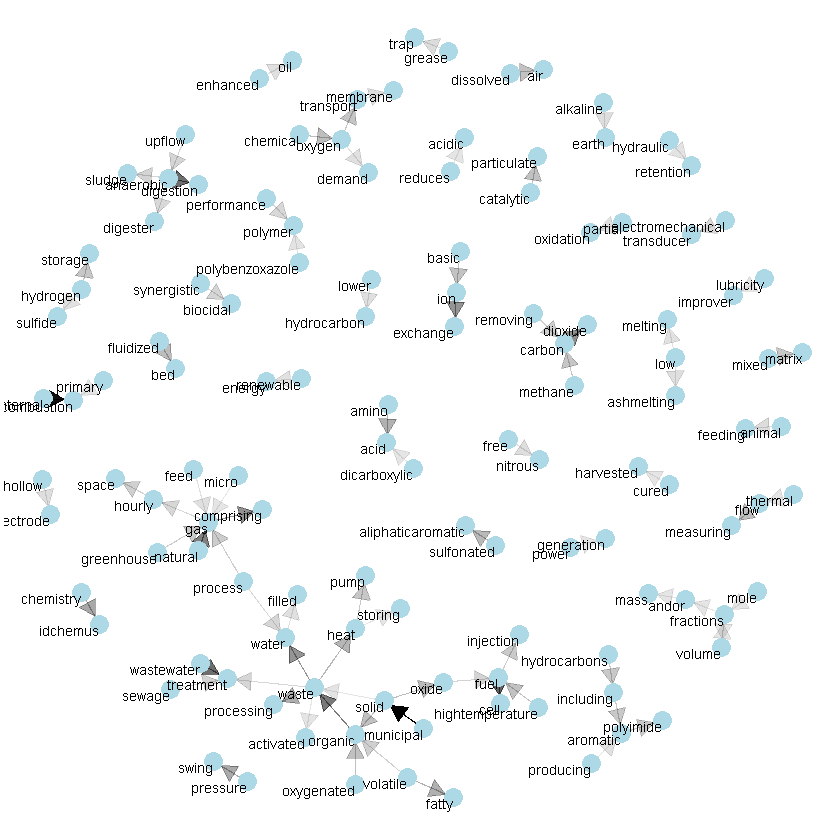

In [95]:
a <- grid::arrow(type = "closed", length = unit(.15, "inches"))
ggraph(trigram_graph, layout = "fr") +
  geom_edge_link(aes(edge_alpha = n), show.legend = FALSE,
                 arrow = a, end_cap = circle(.07, 'inches')) +
  geom_node_point(color = "lightblue", size = 5) +
  geom_node_text(aes(label = name), vjust = 1, hjust = 1, size=3) +
  theme_void()

### Word correlations

In [65]:
abstract_section_words <- df_with_patent_id %>%
  filter(IssueDate == "2016") %>%
  mutate(section = row_number() %/%4) %>%
  filter(section > 0) %>%
  unnest_tokens(word, Abstract) %>%
  filter(!word %in% all_stops$word)

In [66]:
word_pairs <- abstract_section_words %>%
  pairwise_count(word, section, sort = TRUE)

In [67]:
word_cors <- abstract_section_words %>%
  group_by(word) %>%
  filter(n() >= 50) %>%
  pairwise_cor(word, section, sort = TRUE)
word_cors

item1,item2,correlation
comprising,relates,1.0000000
produce,relates,1.0000000
plant,relates,1.0000000
relates,comprising,1.0000000
produce,comprising,1.0000000
plant,comprising,1.0000000
relates,produce,1.0000000
comprising,produce,1.0000000
plant,produce,1.0000000
additional,carbon,1.0000000


Selecting by correlation


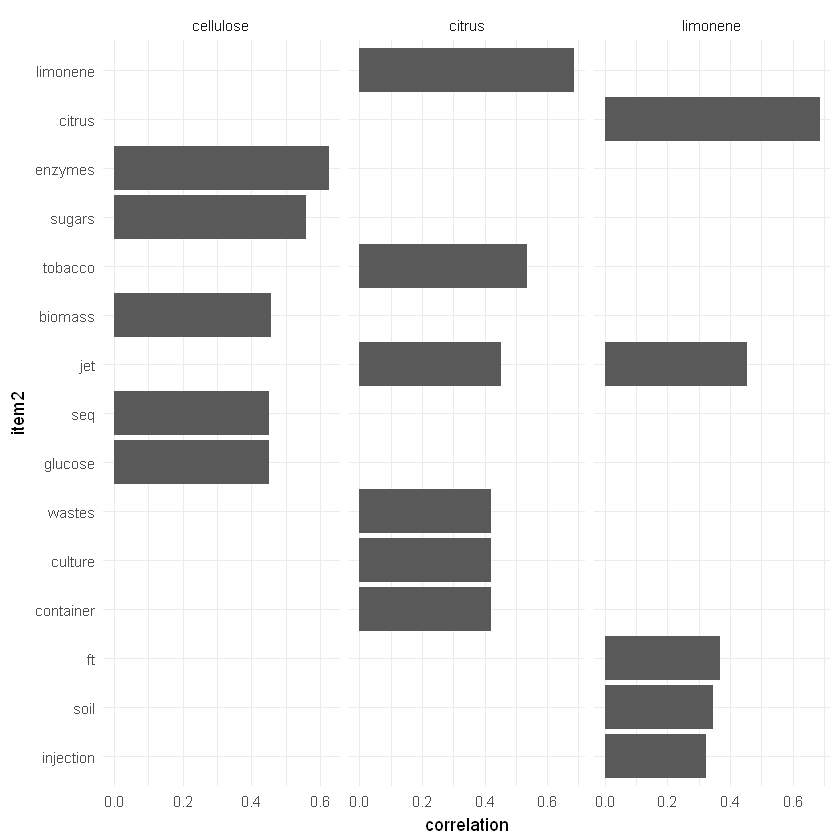

In [93]:
word_cors %>%
  filter(item1 %in% c("cellulose", "citrus", "limonene")) %>%
  group_by(item1) %>%
  top_n(5) %>%
  ungroup() %>%
  mutate(item2 = reorder(item2, correlation)) %>%
  ggplot(aes(item2, correlation)) +
  geom_bar(stat = "identity") +
  facet_wrap(~ item1, scales = "free_x") +
  coord_flip()

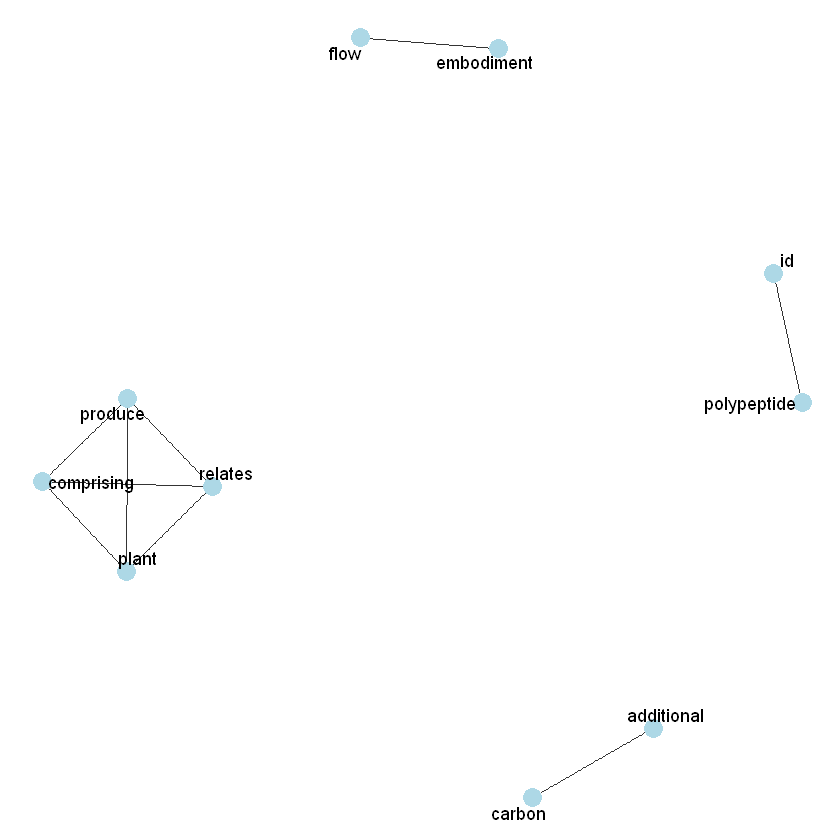

In [69]:
word_cors %>%
  filter(correlation > .95) %>%
  graph_from_data_frame() %>%
  ggraph(layout = "fr") +
  geom_edge_link(aes(edge_alpha = correlation), show.legend = FALSE) +
  geom_node_point(color = "lightblue", size = 5) +
  geom_node_text(aes(label = name), repel = TRUE) +
  theme_void()

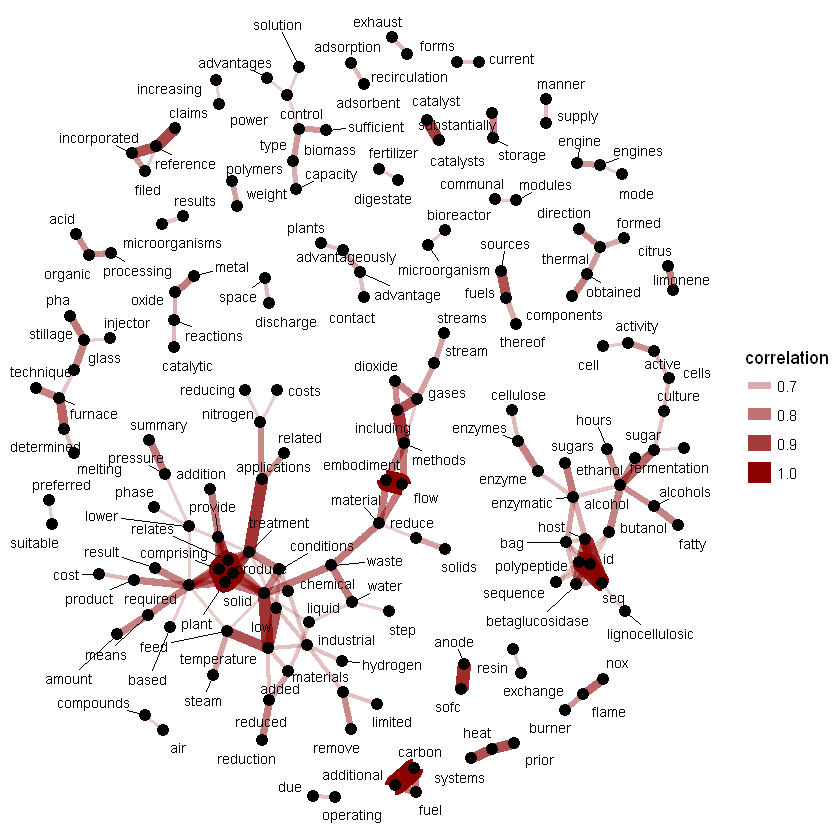

In [78]:
set.seed(1)
word_cors %>%
  filter(correlation > .60) %>%
  graph_from_data_frame() %>%
  ggraph(layout = "fr") +
  geom_edge_link(aes(edge_alpha = correlation, edge_width = correlation),
                 edge_colour = 'darkred',
                 show.legend = TRUE) +
  geom_node_point(size = 3) +
  geom_node_text(aes(label = name), repel = TRUE, size=3,
                 point.padding = unit(0.2, "lines")) +
  theme_void()

### Latent dirichlet analysis

In [51]:
#Load data
filename = "biogas1.csv" # "fw1.csv" is our raw data which has been slightly pre-processed in Excel. 
df <- read.csv(filename)
df$text <- as.character(df$text)
df$IssueDate <- as.factor(df$IssueDate)

In [53]:
str(df)

'data.frame':	1293 obs. of  6 variables:
 $ PatentNo : Factor w/ 1293 levels "3956491","3979259",..: 1012 145 814 18 948 1044 100 459 501 890 ...
 $ title    : Factor w/ 1145 levels " which is sent to the disrober with subsequent decomposition of the solution into CO<sub>2 </sub>and processing"| __truncated__,..: 156 220 807 73 178 5 102 231 106 66 ...
 $ abstract : Factor w/ 1175 levels ""," A biochemically enhanced hybrid anaerobic reactor (BEHAR) system has been developed for treatment of high stre"| __truncated__,..: 963 105 1015 101 517 875 107 1040 903 1042 ...
 $ text     : chr  "CROSS REFERENCE TO RELATED APPLICATIONS This application is a &#xa7;371 National Stage Application of PCT/EP201"| __truncated__ "The invention relates to fermentation plants, and more particularly to control of fermentation plants. Two know"| __truncated__ "The present invention concerns a procedure to produce biodiesel or other bio-fuel of natural origin from organi"| __truncated__ "This invention rela

In [54]:
#Remove common stop words
data("stop_words")

# Custom stop words
additional_stop_words <- data_frame(word=c("figref", "idrefdrawingsfig", "bb", "xb", "patent", "document", 
                                           "xbsubsub", "fig"， "invention"),
                                   lexicon = rep("custom"))

#Bind stop word data
all_stops <- bind_rows(stop_words, additional_stop_words)

In [55]:
#Define a function to clean our text
#Here we lemmatize words and remove punctiation, numbers, and stopwords. 
clean_patent <- function(df, column_name){
    #clean the text of a patent : put to lowercase, lemmatize, remove punctuation and numbers
    start.time <- Sys.time()
    cleaned_text <- df[,c(column_name)]%>%
        tolower() %>%
        lemmatize_strings() %>%
        removeWords(all_stops$word) %>%
        removeNumbers() %>%
        removePunctuation()
    end.time <- Sys.time()
    time.taken <- end.time - start.time
    time.taken
    return(cleaned_text)  
}

In [56]:
df[,c("text")] <- clean_patent(df, "text")

In [57]:
#Define function to create a document-term matrix
create_document_matrix <- function(df){
    #create document matrix
    text_lda <- df %>%
        mutate(PatentNo = as.integer(PatentNo)) %>%
        as_tibble() %>%
        select_("text","PatentNo") %>% 
        unnest_tokens(word, text) %>%
        count(PatentNo, word) %>% 
        cast_dtm(PatentNo, word, n)
    text_lda
}

In [58]:
#Split the data between train and validation set : the validation set will be used to get the right number of topics
n <- nrow(df)
splitter <- sample(1:n, round(n * 0.7))
train_set <- df[splitter, ]
valid_set <- df[-splitter, ]

In [59]:
str(train_set)

'data.frame':	905 obs. of  6 variables:
 $ PatentNo : Factor w/ 1293 levels "3956491","3979259",..: 800 303 1194 79 916 1149 1152 1083 940 555 ...
 $ title    : Factor w/ 1145 levels " which is sent to the disrober with subsequent decomposition of the solution into CO<sub>2 </sub>and processing"| __truncated__,..: 543 811 768 277 560 217 128 1058 232 418 ...
 $ abstract : Factor w/ 1175 levels ""," A biochemically enhanced hybrid anaerobic reactor (BEHAR) system has been developed for treatment of high stre"| __truncated__,..: 812 1155 729 68 368 1041 521 381 702 836 ...
 $ text     : chr  "field       relate  water treatment     method  system  biologically treat wastewater   significant concentrati"| __truncated__ "field      relate  process  equipment  economically convert manure  sewage  fertilizer   certify organic fertil"| __truncated__ "incorporation  reference   priority application    application    foreign  domestic priority claim  identify   "| __truncated__ "  relate   proc

In [60]:
#Make a document term matrix for the training set and the validation set
lda_document_matrix_train <- create_document_matrix(train_set)
lda_document_matrix_valid <- create_document_matrix(valid_set)

In [61]:
#Function to create LDA model based on different topics
create_lda_model <- function(document_matrix, num_topics, seed=1234){
    #create lda model
    lda_model <- LDA(document_matrix, k=num_topics, control = list(seed=seed))
    lda_model
}

In [62]:
# Let's try out different values of K. CAREFUL, this takes a few hours to run. 
candidate_k <- c(2, 4, 8, 10, 20, 30) 
perplexities <- vector(mode="list", length=length(candidate_k))
names(perplexities) <- candidate_k
index <- 1
start.time <- Sys.time()
for(k in candidate_k){
    print(paste("k=",k,sep=""))
    lda_model <- create_lda_model(lda_document_matrix_train, k)
    perplexities[index] <- perplexity(lda_model, newdata = lda_document_matrix_valid)
    index <- index + 1
}
end.time <- Sys.time()
print(end.time - start.time)
print(perplexities)

[1] "k=2"
[1] "k=4"
[1] "k=8"
[1] "k=10"
[1] "k=20"
[1] "k=30"
Time difference of 45.98724 mins
$`2`
[1] 1347.823

$`4`
[1] 1197.776

$`8`
[1] 1067

$`10`
[1] 1042.917

$`20`
[1] 930.9594

$`30`
[1] 886.8507



In [63]:
# save(perplexities, file = "perplexities.rda")
#load("perplexities.rda")

In [64]:
Topics <- candidate_k
Perplexity <- c(perplexities[[1]],perplexities[[2]],perplexities[[3]],perplexities[[4]],perplexities[[5]],perplexities[[6]])

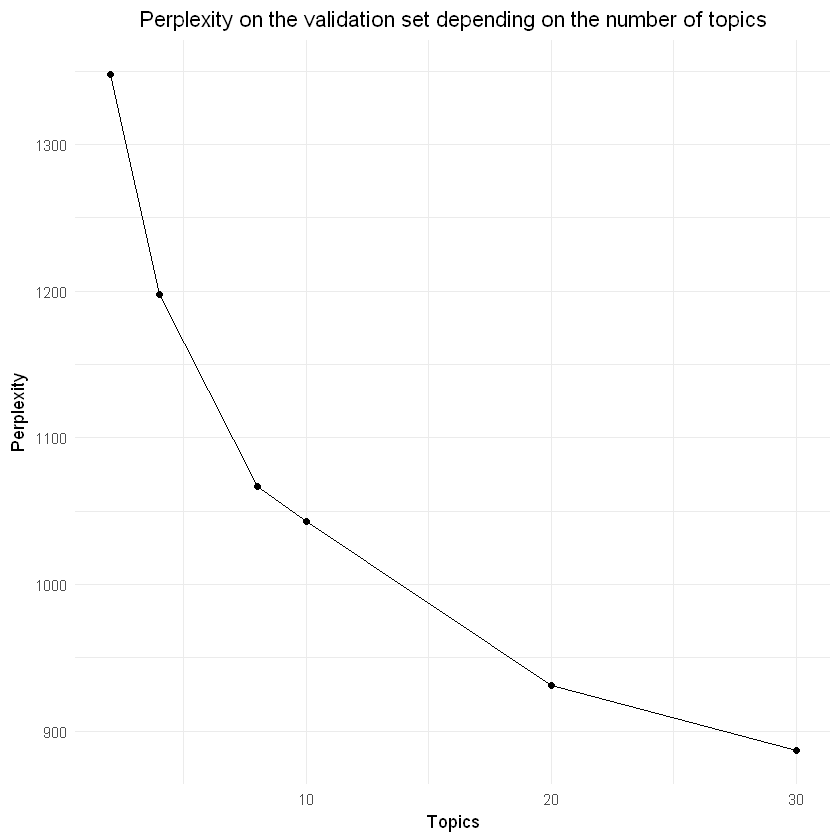

In [65]:
num_topics_vs_perplexity <- data.frame(Topics, Perplexity)
ggplot(num_topics_vs_perplexity, aes(Topics, Perplexity)) + 
    geom_line() + 
    geom_point() + 
    ggtitle("Perplexity on the validation set depending on the number of topics") +
    theme(plot.title = element_text(hjust = 0.5))

In [66]:
lda_df <- as_tibble(text_df)

In [67]:
abstract_lda <- lda_df %>% 
  unnest_tokens(word, text) %>% 
  anti_join(all_stops) %>% 
  count(line, word) %>% 
  cast_dtm(line, word, n)

Joining, by = "word"


In [68]:
abstract_lda

<<DocumentTermMatrix (documents: 1292, terms: 34110)>>
Non-/sparse entries: 440944/43629176
Sparsity           : 99%
Maximal term length: 110
Weighting          : term frequency (tf)

In [69]:
ap_lda <- LDA(abstract_lda, k=20, control = list(seed=1234))

In [70]:
ap_topics <- tidy(ap_lda, matrix = "beta")
ap_topics

topic,term,beta
1,ability,4.445610e-04
2,ability,7.342462e-04
3,ability,2.285736e-04
4,ability,1.862542e-04
5,ability,5.666924e-05
6,ability,8.900449e-04
7,ability,3.084268e-04
8,ability,2.055300e-04
9,ability,6.786029e-09
10,ability,2.626265e-04


In [71]:
ap_top_terms <- ap_topics %>%
  group_by(topic) %>%
  top_n(10, beta) %>%
  ungroup() %>%
  arrange(topic, -beta)

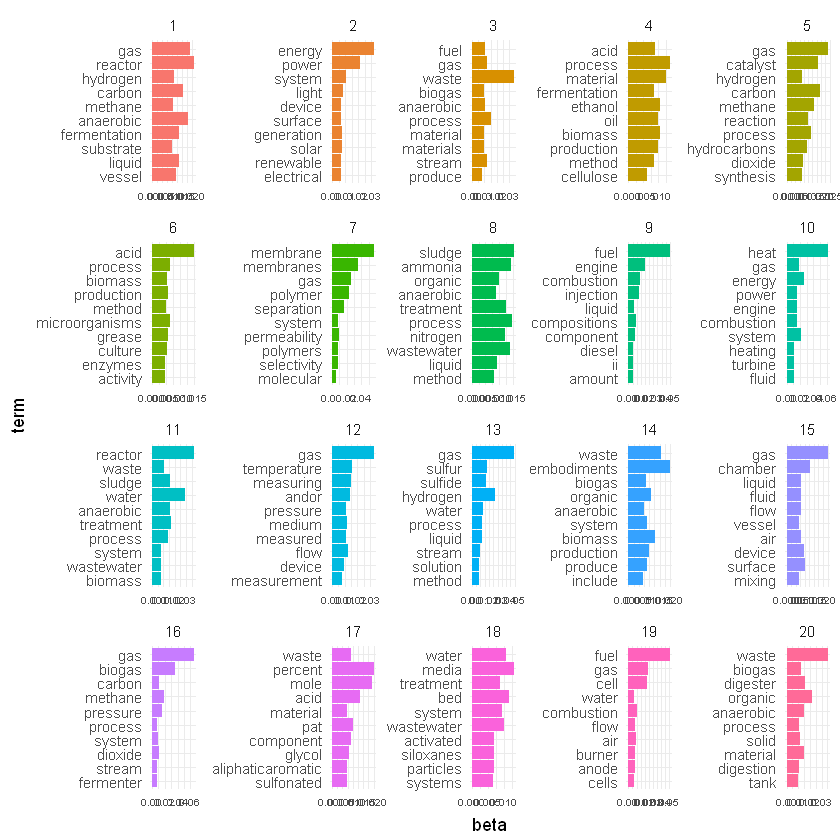

In [72]:
ap_top_terms %>%
  mutate(term = reorder(term, beta)) %>%
  ggplot(aes(term, beta, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  coord_flip() +
  theme(axis.text.x=element_text(size=rel(0.7)))

In [73]:
#beta spread topics 1 and 2
beta_spread <- ap_topics %>%
  mutate(topic = paste0("topic", topic)) %>%
  spread(topic, beta) %>%
  filter(topic1 > .001 | topic2 > .001) %>%
  mutate(log_ratio = log2(topic2 / topic1))

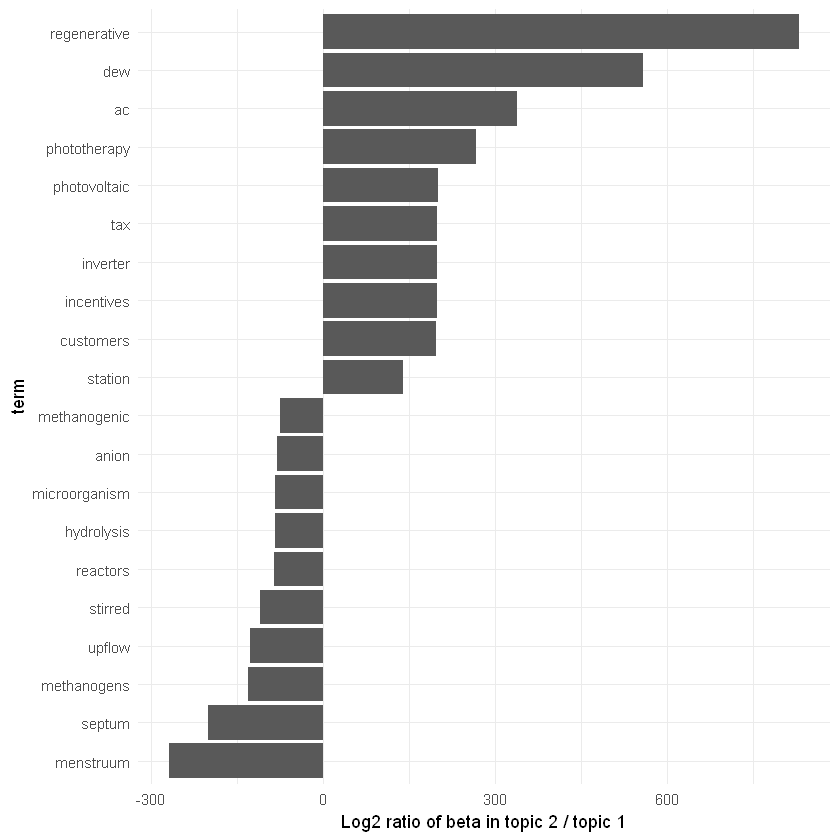

In [74]:
#beta spread topics 1 and 2 visualized
beta_spread %>%
  group_by(direction = log_ratio > 0) %>%
  top_n(10, abs(log_ratio)) %>%
  ungroup() %>%
  mutate(term = reorder(term, log_ratio)) %>%
  ggplot(aes(term, log_ratio)) +
  geom_col() +
  labs(y = "Log2 ratio of beta in topic 2 / topic 1") +
  coord_flip()